In [2]:
import torch

class Vocab:
    def __init__(self, id2word=None):
        if id2word is not None:
            self.id2word = id2word
        else:
            self.id2word = {0: "<UNK>", 1: "<END>", 2: "<START>", 3: "<PAD>"}
        self.word2id = {v: k for k, v in self.id2word.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.word2id["<UNK>"])

    def __len__(self):
        return len(self.id2word)

    def add(self, word):
        if word not in self.word2id:
            index = len(self.id2word)
            self.id2word[index] = word
            self.word2id[word] = index
        return self.word2id[word]

    def indices2word(self, sents):
        return [[self.id2word[idx] for idx in sent] for sent in sents]

    def words2indices(self, ids_word):
        return [self.word2id[word] for word in ids_word]

    def tensor_input_to(self, sents):
      max_len = max(len(sent) for sent in sents)
      padded_sents = []
      for sent in sents:
        sent_ids = []
        for word in sent:
          word_id = self.word2id.get(word, self.word2id["<UNK>"])  # Consistent handling of unknown words
          sent_ids.append(word_id)
        # print(sent_ids)
        padded_sents.append(sent_ids + [self.word2id["<PAD>"]] * (max_len - len(sent_ids)))
      return torch.tensor(padded_sents)


    def corpus(self, corpus_text, size=5000, cutoff_freq=5, frac_remove=0.2):
        # Create vocab from corpus text
        word_freq = {}
        for sentence in corpus_text:
            for word in sentence:
                word_freq[word] = word_freq.get(word, 0) + 1

        # Sort words by frequency and filter out less useful words
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        useful_words = [word for word, freq in sorted_words if freq >= cutoff_freq]
        useful_words = useful_words[:int(len(useful_words) * (1 - frac_remove))]
        vocab_words = useful_words[:size]

        # Create vocab object
        vocab = Vocab()
        for word in vocab_words:
            vocab.add(word)

        return vocab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json


file_path = "/kaggle/input/qa-pos/train.json"

# Load the JSON file
with open(file_path, "r") as file:
    data = json.load(file)

text_data = data['text']
verb_index_data = data['verb_index']
sr_label_data = data['srl_frames']
word_indices_data = data['words_indices']

print("Number of sentences:", len(text_data))
print("First sentence:", text_data[0])
print("Corresponding verb index:", verb_index_data[0])
print("Semantic role labels for first sentence:", sr_label_data[0])
print("Word indices for first sentence:", word_indices_data[0])


Number of sentences: 13310
First sentence: ['A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.']
Corresponding verb index: 10
Semantic role labels for first sentence: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O']
Word indices for first sentence: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [4]:
vocab = Vocab()

vocab = vocab.corpus(text_data, size=20000, cutoff_freq=1, frac_remove=0.3)
tag_mapping = {
  'O': 0, 'B-ARG0': 1, 'I-ARG0': 2, 'B-ARG1': 3, 'I-ARG1': 4,
  'B-ARG2': 5, 'I-ARG2': 6, 'B-ARGM-LOC': 7,
  'I-ARGM': 8, 'B-ARGM-TMP': 9, 'I-ARGM-TMP': 10}

In [6]:
vocab.__getitem__('progress')

1576

In [17]:
vocab.id2word[0]

'<UNK>'

In [18]:
len(vocab)

13361

In [5]:
def convert_nested_list(data, my_dict, target_size):

  new_data = []
  for inner_list in data:
    new_inner_list = []
    for item in inner_list:
      if isinstance(item, str):
        new_inner_list.append(my_dict.get(item))
      else:
        new_inner_list.append(item)

    # Pad the list with 0s to reach the target size
    new_inner_list.extend([0] * (target_size - len(new_inner_list)))
    new_data.append(new_inner_list)
  return new_data

In [6]:
labels_train = convert_nested_list(sr_label_data, tag_mapping,50)

In [7]:

def convert_nested_list_to_tensor(data):

  # Base case: If it's a number, convert it to a scalar tensor
  if not isinstance(data, list):
    return torch.tensor(data)

  # Recursive case: Convert each sub-list to a tensor and stack them
  tensors = [convert_nested_list_to_tensor(item) for item in data]
  return torch.stack(tensors)
labels_train = convert_nested_list_to_tensor(labels_train)

In [8]:
labels_train.shape

torch.Size([13310, 50])

In [8]:
tensor_train =vocab.tensor_input_to(text_data)

In [9]:
v_index = []
for i,tens in enumerate(tensor_train):
  v_index.append(tens[verb_index_data[i]])


In [10]:
combined_tensor = torch.tensor(verb_index_data)
combined_tensor.shape

torch.Size([13310])

In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, inputs, labels, verb_index):
    self.inputs = inputs
    self.labels = labels
    self.verb_index = verb_index  # Add verb_index as input argument

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    input_tensor = self.inputs[idx]
    label = self.labels[idx]
    verb_idx = self.verb_index[idx]  
    return input_tensor, label, verb_idx  

train_dataset = CustomDataset(vocab.tensor_input_to(text_data), labels_train, combined_tensor)

# Define batch size
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


In [12]:

file_path_ = "/kaggle/input/qa-pos/valid.json"

# Load the JSON file
with open(file_path, "r") as file:
    data_val = json.load(file)

text_data_val = data_val['text']
verb_index_data_val = data_val['verb_index']
sr_label_data_val = data_val['srl_frames']
word_indices_data_val = data_val['words_indices']

In [13]:
labels_val = convert_nested_list(sr_label_data_val, tag_mapping,50)
labels_val = convert_nested_list_to_tensor(labels_val)
torch.tensor(verb_index_data_val)

tensor([10,  4, 12,  ...,  8,  5, 16])

In [14]:
val_dataset = CustomDataset(vocab.tensor_input_to(text_data_val), labels_val, torch.tensor(verb_index_data_val))

batch_size = 32

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### LSTM Model

In [18]:
import torch
import torch.nn as nn

class LSTMForSemanticRolePrediction(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(LSTMForSemanticRolePrediction, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, tokens, verb):

        embedded_tokens = self.embedding(tokens)  # (batch_size, sequence_length, embedding_dim)

        lstm_output, (hidden_state, _) = self.lstm(embedded_tokens)  # lstm_output: (batch_size, sequence_length, hidden_dim)

        selected_outputs = lstm_output[torch.arange(lstm_output.size(0)), verb]  # shape: (32, 64)
        expanded_selected_outputs = selected_outputs.unsqueeze(1).expand(-1, lstm_output.size(1), -1)  # shape: (32, 50, 64)

        concatenated_output = torch.cat([lstm_output, expanded_selected_outputs], dim=-1)  # shape: (32, 50, 128)

        output = self.linear(concatenated_output)  # (batch_size, sequence_length, output_dim)

        return output


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your loss function
criterion = nn.CrossEntropyLoss()

embedding_dim=64
hidden_dim=64
num_layers=1
output_dim=11
num_epochs=10
learning_rate=0.001
vocab_size=len(vocab)
model = LSTMForSemanticRolePrediction(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()  
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_inputs, batch_labels, batch_verb in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs, batch_verb)
        loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(batch_inputs)
        _, predicted = torch.max(outputs.data, 2)
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += len(batch_labels) * len(batch_labels[0])

    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval() 
    with torch.no_grad():
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0

        for val_batch_inputs, val_batch_labels, val_batch_verb in val_loader:
            val_outputs = model(val_batch_inputs, val_batch_verb)
            val_loss = criterion(val_outputs.view(-1, output_dim), val_batch_labels.view(-1))

            total_val_loss += val_loss.item() * len(val_batch_inputs)
            _, val_predicted = torch.max(val_outputs.data, 2)
            total_val_correct += (val_predicted == val_batch_labels).sum().item()
            total_val_samples += len(val_batch_labels) * len(val_batch_labels[0])

    val_epoch_loss = total_val_loss / len(val_loader.dataset)
    val_epoch_accuracy = total_val_correct / total_val_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.4201, Train Accuracy: 0.9186, Val Loss: 0.3047, Val Accuracy: 0.9288
Epoch 2/10, Train Loss: 0.2792, Train Accuracy: 0.9290, Val Loss: 0.2729, Val Accuracy: 0.9284
Epoch 3/10, Train Loss: 0.2537, Train Accuracy: 0.9294, Val Loss: 0.2515, Val Accuracy: 0.9293
Epoch 4/10, Train Loss: 0.2335, Train Accuracy: 0.9310, Val Loss: 0.2404, Val Accuracy: 0.9278
Epoch 5/10, Train Loss: 0.2161, Train Accuracy: 0.9333, Val Loss: 0.2290, Val Accuracy: 0.9272
Epoch 6/10, Train Loss: 0.2009, Train Accuracy: 0.9361, Val Loss: 0.2139, Val Accuracy: 0.9307
Epoch 7/10, Train Loss: 0.1872, Train Accuracy: 0.9392, Val Loss: 0.1967, Val Accuracy: 0.9352
Epoch 8/10, Train Loss: 0.1744, Train Accuracy: 0.9423, Val Loss: 0.1840, Val Accuracy: 0.9383
Epoch 9/10, Train Loss: 0.1628, Train Accuracy: 0.9456, Val Loss: 0.1752, Val Accuracy: 0.9404
Epoch 10/10, Train Loss: 0.1527, Train Accuracy: 0.9486, Val Loss: 0.1626, Val Accuracy: 0.9445


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

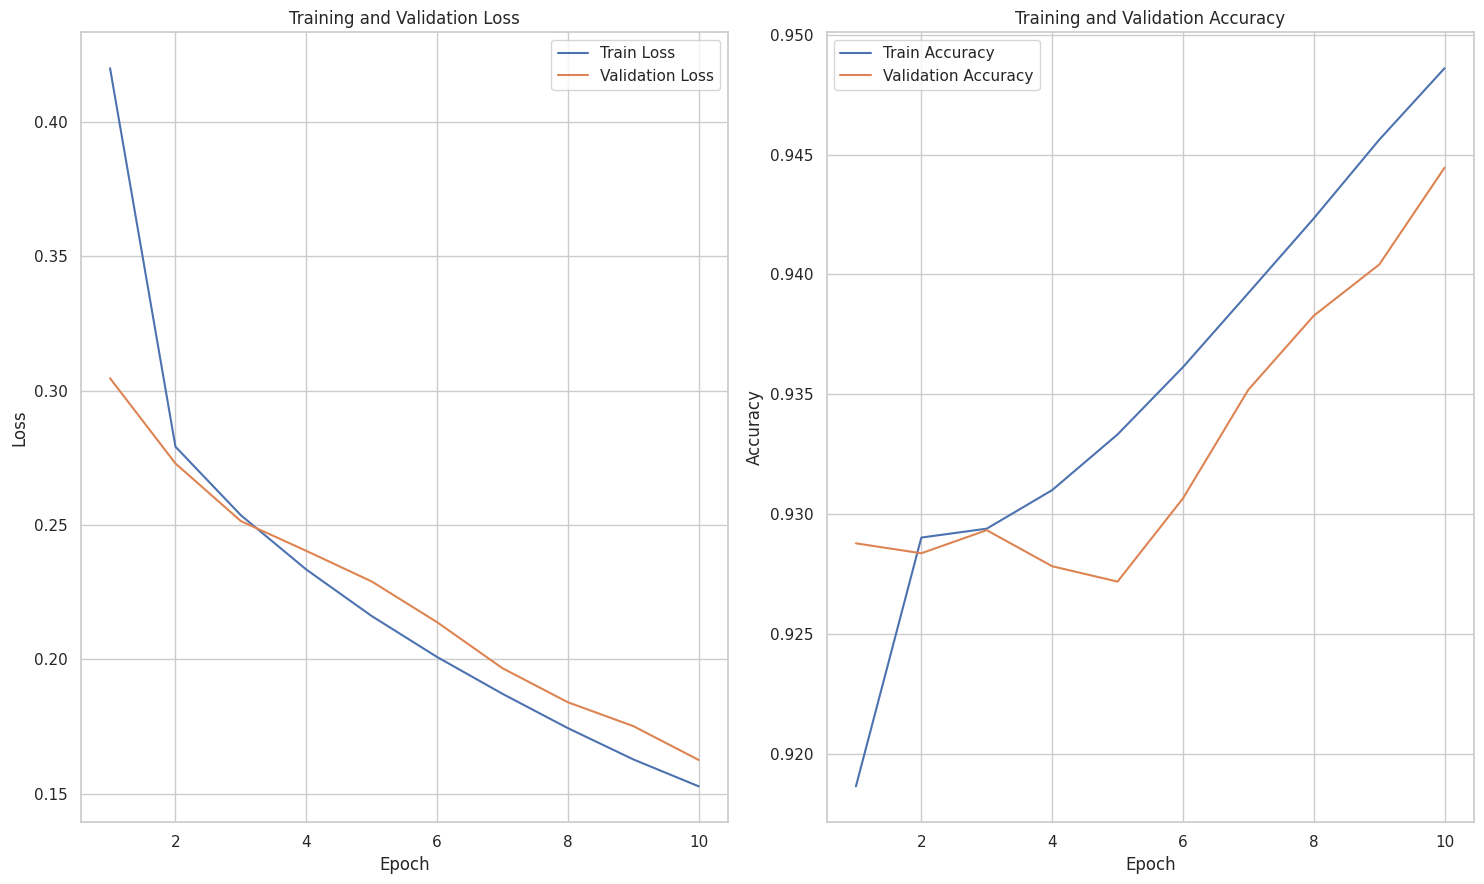

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(15, 9))

sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=train_losses, label='Train Loss')
sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=train_accuracies, label='Train Accuracy')
sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=val_accuracies, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import f1_score
import numpy as np

true_labels = []
predicted_labels = []

model.eval()  
with torch.no_grad():
    for val_batch_inputs, val_batch_labels, val_batch_verb in val_loader:
        val_outputs = model(val_batch_inputs, val_batch_verb)
        _, val_predicted = torch.max(val_outputs.data, 2)

        true_labels.extend(val_batch_labels.view(-1).tolist())
        predicted_labels.extend(val_predicted.view(-1).tolist())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

f1 = f1_score(true_labels, predicted_labels, average='micro')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9445


In [23]:
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.5282


### GRU

In [ ]:
pip install torchviz


In [24]:
import torch
import torch.nn as nn

class GRUForSemanticRolePrediction(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(GRUForSemanticRolePrediction, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, tokens, verb):
        # tokens: tensor of token indices (batch_size, sequence_length)
        # verb: tensor of verb indices (batch_size, 1)

        # Embedding layer
        embedded_tokens = self.embedding(tokens)  # (batch_size, sequence_length, embedding_dim)

        # GRU layer
        gru_output, hidden_state = self.gru(embedded_tokens)  # gru_output: (batch_size, sequence_length, hidden_dim)

        selected_outputs = gru_output[torch.arange(gru_output.size(0)), verb.squeeze()]  # shape: (batch_size, hidden_dim)
        expanded_selected_outputs = selected_outputs.unsqueeze(1).expand(-1, gru_output.size(1), -1)  # shape: (batch_size, sequence_length, hidden_dim)

        concatenated_output = torch.cat([gru_output, expanded_selected_outputs], dim=-1)  # shape: (batch_size, sequence_length, 2 * hidden_dim)

        # Linear layer for prediction
        output = self.linear(concatenated_output)  # (batch_size, sequence_length, output_dim)

        return output


In [25]:
print(model)

LSTMForSemanticRolePrediction(
  (embedding): Embedding(13361, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (linear): Linear(in_features=128, out_features=11, bias=True)
)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your loss function
criterion = nn.CrossEntropyLoss()

embedding_dim=64
hidden_dim=64
num_layers=1
output_dim=11
num_epochs=10
learning_rate=0.001
vocab_size=len(vocab)
# Instantiate the model
model = GRUForSemanticRolePrediction(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_inputs, batch_labels, batch_verb in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs, batch_verb)
        loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(batch_inputs)
        _, predicted = torch.max(outputs.data, 2)
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += len(batch_labels) * len(batch_labels[0])

    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0

        for val_batch_inputs, val_batch_labels, val_batch_verb in val_loader:
            val_outputs = model(val_batch_inputs, val_batch_verb)
            val_loss = criterion(val_outputs.view(-1, output_dim), val_batch_labels.view(-1))

            total_val_loss += val_loss.item() * len(val_batch_inputs)
            _, val_predicted = torch.max(val_outputs.data, 2)
            total_val_correct += (val_predicted == val_batch_labels).sum().item()
            total_val_samples += len(val_batch_labels) * len(val_batch_labels[0])

    val_epoch_loss = total_val_loss / len(val_loader.dataset)
    val_epoch_accuracy = total_val_correct / total_val_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.3995, Train Accuracy: 0.9181, Val Loss: 0.3005, Val Accuracy: 0.9286
Epoch 2/10, Train Loss: 0.2759, Train Accuracy: 0.9293, Val Loss: 0.2756, Val Accuracy: 0.9275
Epoch 3/10, Train Loss: 0.2498, Train Accuracy: 0.9300, Val Loss: 0.2575, Val Accuracy: 0.9249
Epoch 4/10, Train Loss: 0.2280, Train Accuracy: 0.9320, Val Loss: 0.2416, Val Accuracy: 0.9236
Epoch 5/10, Train Loss: 0.2091, Train Accuracy: 0.9350, Val Loss: 0.2282, Val Accuracy: 0.9245
Epoch 6/10, Train Loss: 0.1932, Train Accuracy: 0.9382, Val Loss: 0.2188, Val Accuracy: 0.9257
Epoch 7/10, Train Loss: 0.1792, Train Accuracy: 0.9415, Val Loss: 0.2085, Val Accuracy: 0.9282
Epoch 8/10, Train Loss: 0.1665, Train Accuracy: 0.9448, Val Loss: 0.1935, Val Accuracy: 0.9332
Epoch 9/10, Train Loss: 0.1555, Train Accuracy: 0.9480, Val Loss: 0.1745, Val Accuracy: 0.9400
Epoch 10/10, Train Loss: 0.1477, Train Accuracy: 0.9502, Val Loss: 0.1451, Val Accuracy: 0.9504


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

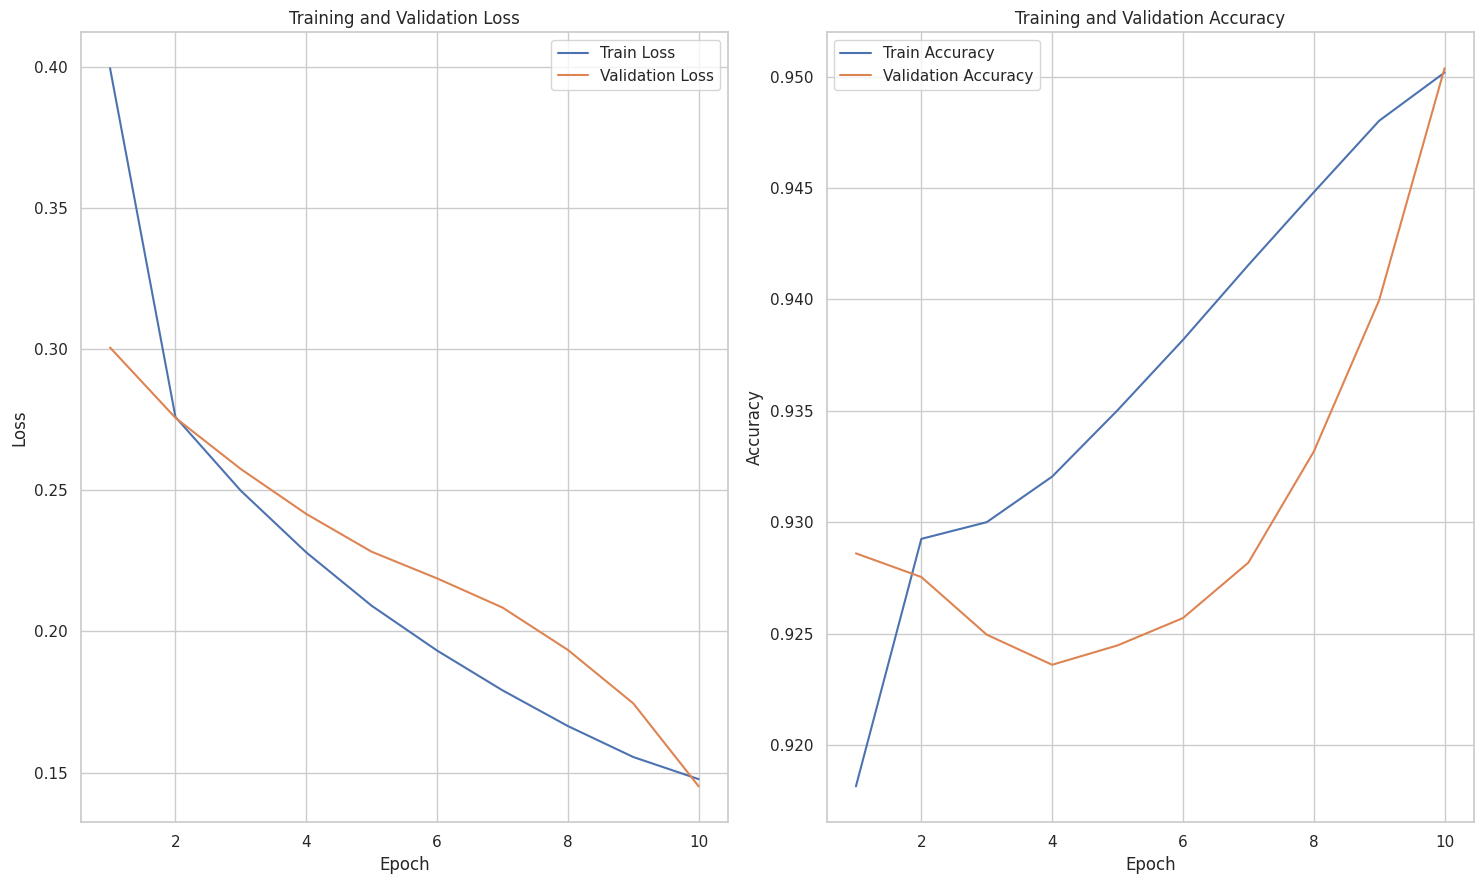

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

# Plot training and validation loss
sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=train_losses, label='Train Loss')
sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and validation accuracy
sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=train_accuracies, label='Train Accuracy')
sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=val_accuracies, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import f1_score
import numpy as np

true_labels = []
predicted_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for val_batch_inputs, val_batch_labels, val_batch_verb in val_loader:
        val_outputs = model(val_batch_inputs, val_batch_verb)
        _, val_predicted = torch.max(val_outputs.data, 2)

        true_labels.extend(val_batch_labels.view(-1).tolist())
        predicted_labels.extend(val_predicted.view(-1).tolist())

# Convert labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute F1 score
f1 = f1_score(true_labels, predicted_labels, average='micro')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9504


In [31]:
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.5504


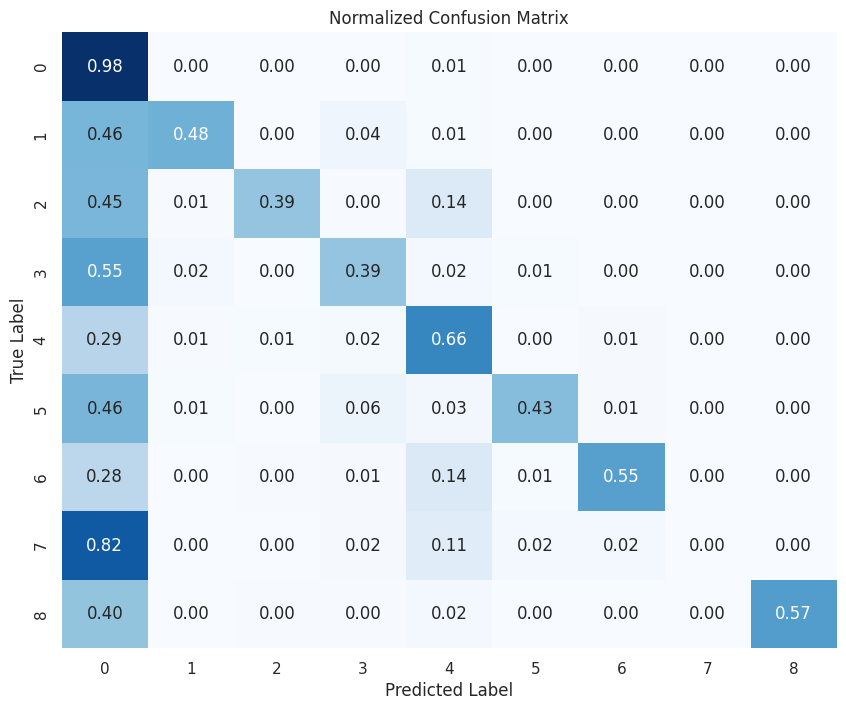

In [32]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### QA Dataset

In [15]:
def generate_qa_pairs(data):
    question_list = []
    answer_list = []
    for sentence, verb_index, labels in zip(data['text'], data['verb_index'], data['srl_frames']):
        for label in set(labels):
            if not label.startswith('O'):
                answer = ['<START>'] + [token for token, lab in zip(sentence, labels) if lab == label] + ['<END>']
                question = [sentence[verb_index], '<PAD>'] + sentence + [label]
                question_list.append(question)
                answer_list.append(answer)
    return question_list, answer_list


In [16]:
questions_train, answers_train = generate_qa_pairs(data)
questions_val, answers_val = generate_qa_pairs(data_val)

In [17]:
vocab = Vocab()

# Call the corpus function to construct the vocabulary
vocab = vocab.corpus(questions_train, size=20000, cutoff_freq=1, frac_remove=0.2)


In [18]:
from torch.utils.data import Dataset

class qadataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.answers)

    def __getitem__(self, index):
        return self.questions[index], self.answers[index]

In [19]:
train_dataset_qa = qadataset(vocab.tensor_input_to(questions_train), vocab.tensor_input_to(answers_train))
val_dataset_qa = qadataset(vocab.tensor_input_to(questions_val), vocab.tensor_input_to(answers_val))

In [20]:
batch_size = 32
train_loader_qa = torch.utils.data.DataLoader(train_dataset_qa, batch_size=batch_size, shuffle=True)
val_loader_qa = torch.utils.data.DataLoader(val_dataset_qa, batch_size=batch_size)

In [50]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip /root/glove.6B.zip

--2024-05-11 06:31:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... failed: Temporary failure in name resolution.
wget: unable to resolve host address 'nlp.stanford.edu'
unzip:  cannot find or open /root/glove.6B.zip, /root/glove.6B.zip.zip or /root/glove.6B.zip.ZIP.


In [21]:
import numpy as np

def load_glove_vectors(glove_file):
    print("Loading GloVe vectors...")
    word_embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            word_embeddings[word] = embedding
    print("GloVe vectors loaded.")
    return word_embeddings

glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
word_embeddings = load_glove_vectors(glove_file)

Loading GloVe vectors...
GloVe vectors loaded.


In [22]:
vocab_size = len(vocab)
embedding_dim = 200

pretrained_embedding = np.zeros((vocab_size, embedding_dim))
for index, (word, _) in enumerate(vocab.word2id.items()):
    if word in word_embeddings:
        pretrained_embedding[index] = word_embeddings[word]
pretrained_embedding = torch.tensor(pretrained_embedding)

In [24]:
pretrained_embedding = pretrained_embedding.to(torch.float32).to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Atention model

In [118]:
class Encoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout_rate):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_dim, batch_first=True, bidirectional=True)
        self.dim_red = nn.Linear(2 * hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, (hidden, cell) = self.rnn(embedded)
        outputs = self.dropout(outputs)
        outputs = self.dim_red(outputs)
        return outputs, hidden, cell

class Attention(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    nn.init.xavier_normal_(self.Wa.weight)  
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.relu(self.Wa(query) + self.Ua(keys)))
    scores = scores.reshape(-1, 1, keys.shape[1])
    weights = nn.functional.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)
    return context, weights
        
class Decoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout_rate):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.attention = Attention(hidden_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.dropout = nn.Dropout(dropout_rate)
        self.rnn = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers=2, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        output = self.dropout(output)
        context, _ = self.attention(output, encoder_outputs)
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg):
        batch_size, trg_length = trg.shape[0], trg.shape[1]
        vocab_size = len(vocab)
        outputs = torch.zeros(batch_size, trg_length-1, vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:,0]
        for t in range(0, trg_length-1):
            decoder_output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = decoder_output.squeeze(1)
            input = trg[:, t+1]
        return outputs

output_dim = len(vocab)
hidden_dim = 128
embedding_dim = 200

encoder = Encoder(pretrained_embedding, hidden_dim, dropout_rate=0.2).to(device)
decoder = Decoder(pretrained_embedding, hidden_dim, output_dim, dropout_rate=0.2).to(device)

model = Seq2Seq(encoder, decoder, device).to(device)


In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

num_epochs = 30

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for src, trg in train_loader_qa:
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        outputs = model(src, trg)
        outputs = outputs.view(-1, model.decoder.output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        loss = criterion(outputs, trg)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        train_correct += (predicted == trg).sum().item()

    train_loss /= len(train_loader_qa)
    train_accuracy = train_correct / sum(len(trg) for _, trg in train_loader_qa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0

    with torch.no_grad():
        for src, trg in val_loader_qa:
            src = src.to(device)
            trg = trg.to(device)

            outputs = model(src, trg)

            outputs = outputs.view(-1, model.decoder.output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(outputs, trg)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            valid_correct += (predicted == trg).sum().item()

    valid_loss /= len(val_loader_qa)
    valid_accuracy = valid_correct / sum(len(trg) for _, trg in val_loader_qa)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")



Epoch 1/30: Train Loss: 0.8665, Train Acc: 13.5137, Valid Loss: 0.6881, Valid Acc: 13.6454
Epoch 2/30: Train Loss: 0.6886, Train Acc: 13.6606, Valid Loss: 0.6491, Valid Acc: 13.6857
Epoch 3/30: Train Loss: 0.6524, Train Acc: 13.6846, Valid Loss: 0.6068, Valid Acc: 13.7050
Epoch 4/30: Train Loss: 0.6180, Train Acc: 13.6989, Valid Loss: 0.5657, Valid Acc: 13.7202
Epoch 5/30: Train Loss: 0.5827, Train Acc: 13.7119, Valid Loss: 0.5242, Valid Acc: 13.7342
Epoch 6/30: Train Loss: 0.5479, Train Acc: 13.7213, Valid Loss: 0.4810, Valid Acc: 13.7511
Epoch 7/30: Train Loss: 0.5137, Train Acc: 13.7301, Valid Loss: 0.4423, Valid Acc: 13.7787
Epoch 8/30: Train Loss: 0.4802, Train Acc: 13.7487, Valid Loss: 0.4068, Valid Acc: 13.8047
Epoch 9/30: Train Loss: 0.4508, Train Acc: 13.7621, Valid Loss: 0.3736, Valid Acc: 13.8531
Epoch 10/30: Train Loss: 0.4241, Train Acc: 13.7802, Valid Loss: 0.3442, Valid Acc: 13.8900
Epoch 11/30: Train Loss: 0.3994, Train Acc: 13.8020, Valid Loss: 0.3215, Valid Acc: 13.92

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

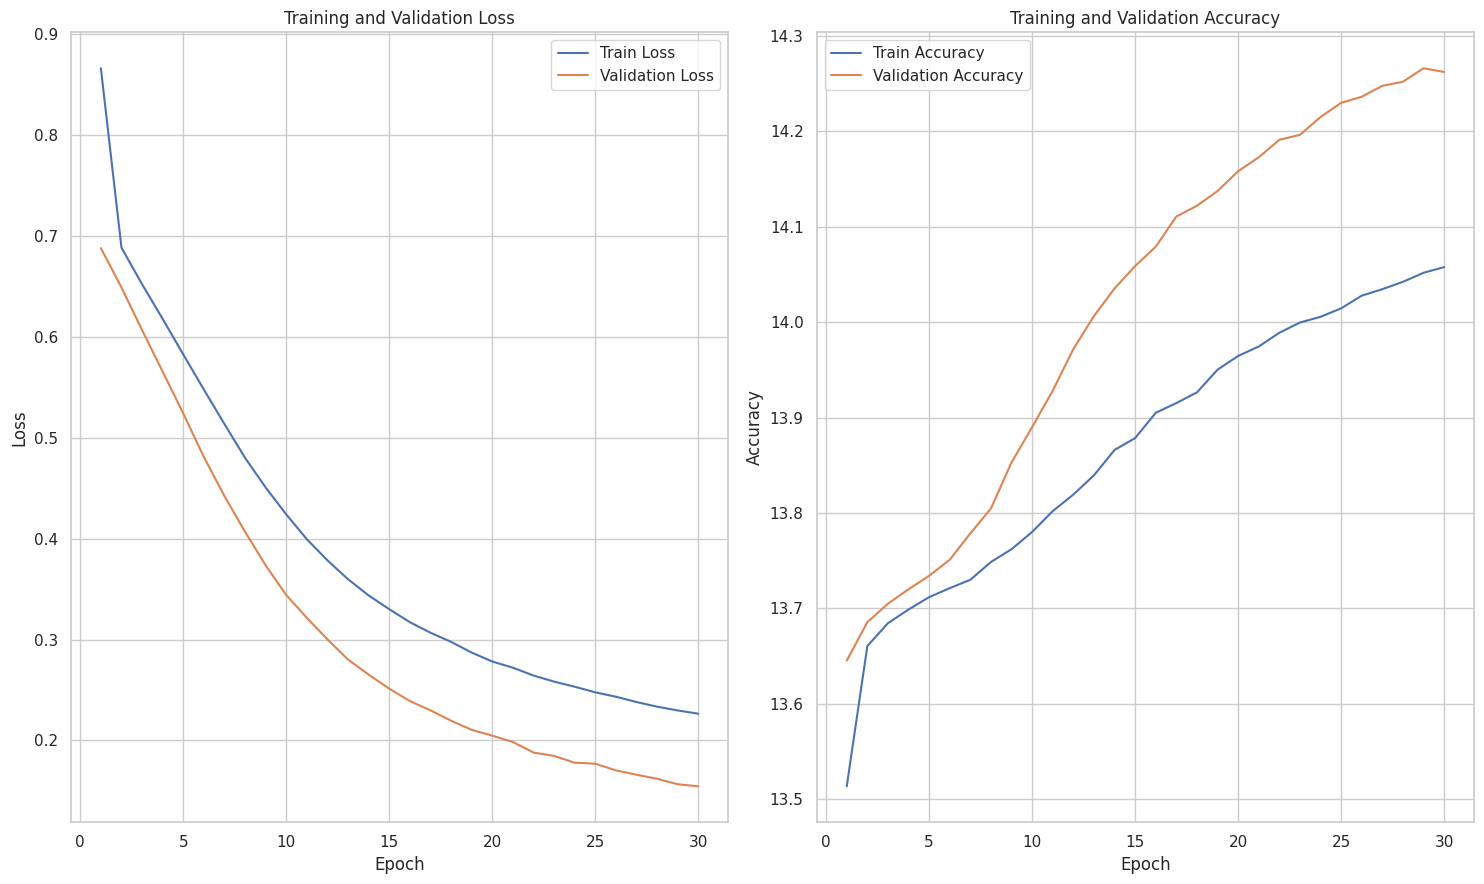

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

# Plot training and validation loss
sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=train_losses, label='Train Loss')
sns.lineplot(ax=axes[0], x=range(1, num_epochs + 1), y=valid_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and validation accuracy
sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=train_accuracies, label='Train Accuracy')
sns.lineplot(ax=axes[1], x=range(1, num_epochs + 1), y=valid_accuracies, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [134]:
from sklearn.metrics import f1_score

y_pred = []
y_valid = []

model.eval()
valid_correct = 0
with torch.no_grad():
    for src, trg in val_loader_qa:
        src = src.to(device)
        trg = trg.to(device)

        outputs = model(src, trg)

        outputs = outputs.view(-1, model.decoder.output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(outputs, trg)

        _, predicted = torch.max(outputs, 1)
        y_valid.extend(trg.cpu().detach().numpy())
        y_pred.extend(predicted.cpu().detach().numpy())

        correct = (predicted == trg).sum().item()
        valid_correct += correct

f1 = f1_score(y_valid, y_pred, average='micro')
print(f"F1-micro Loss: {f1:.4f}")
f1 = f1_score(y_valid, y_pred, average='macro')
print(f"F1-macro Loss: {f1:.4f}")


F1-micro Loss: 0.9508
F1-macro Loss: 0.5763


### inference

In [137]:
def predict_beam(model, src, trg, max_length=50, beam_width=16):
    model.eval()
    with torch.no_grad():
        
        src = src.unsqueeze(0).to(device)
        trg = trg.unsqueeze(0).to(device)
        
        SOS_token = vocab.word2id['<START>']
        EOS_token = vocab.word2id['<END>']
        
        encoder_outputs, hidden, cell = model.encoder(src)
        beams = [(0, [SOS_token], hidden, cell)]
        
        for _ in range(max_length):
            new_beams = []
            for score, tokens, hidden, cell in beams:
                input = torch.tensor([tokens[-1]]).to(device)
                decoder_output, hidden, cell = model.decoder(input, hidden, cell, encoder_outputs)
                log_probs = torch.log_softmax(decoder_output, dim=-1)
                top_log_probs, top_indices = log_probs.topk(beam_width)
                
                for log_prob, index in zip(top_log_probs[0], top_indices[0]):
                    new_score = score + log_prob.item()
                    new_tokens = tokens + [index.item()]
                    new_beams.append((new_score, new_tokens, hidden, cell))
            
            beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
            
            if beams[0][1][-1] == EOS_token:
                break
        
        predicted_tokens = beams[0][1][1:-1]
    
    return predicted_tokens


### QA outputs

In [186]:
src, trg = val_dataset_qa[1]
output_tokens = predict_beam(model, src, trg, max_length=5)

print(vocab.indices2word([src.tolist()])[0][:25])
print(vocab.indices2word([trg.tolist()])[0][:5])
print(vocab.indices2word([output_tokens])[0])

['coordinated', '<PAD>', 'The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.', 'B-ARG1', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<START>', 'offensive', '<END>', '<PAD>', '<PAD>']
['offensive']


In [193]:
src, trg = val_dataset_qa[5]
output_tokens = predict_beam(model, src, trg, max_length=5)

print(vocab.indices2word([src.tolist()])[0][:25])
print(vocab.indices2word([trg.tolist()])[0][:5])
print(vocab.indices2word([output_tokens])[0])

['are', '<PAD>', 'What', 'you', 'are', 'interested', 'in', 'is', 'exactly', 'what', 'our', 'focuses', 'are', '.', 'B-ARG2', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<START>', 'interested', '<END>', '<PAD>', '<PAD>']
['interested']


In [194]:
src, trg = val_dataset_qa[8]
output_tokens = predict_beam(model, src, trg, max_length=5)

print(vocab.indices2word([src.tolist()])[0][:25])
print(vocab.indices2word([trg.tolist()])[0][:5])
print(vocab.indices2word([output_tokens])[0])

['learned', '<PAD>', 'Well', ',', 'from', 'the', 'information', 'and', 'the', 'situation', 'you', 'have', 'learned', ',', 'how', 'would', 'you', 'two', 'interpret', 'some', 'messages', 'sent', 'out', 'by', 'their']
['<START>', 'the', '<END>', '<PAD>', '<PAD>']
['you']


In [197]:
src, trg = val_dataset_qa[6]
output_tokens = predict_beam(model, src, trg, max_length=5)

print(vocab.indices2word([src.tolist()])[0][:25])
print(vocab.indices2word([trg.tolist()])[0][:5])
print(vocab.indices2word([output_tokens])[0])

['learned', '<PAD>', 'Well', ',', 'from', 'the', 'information', 'and', 'the', 'situation', 'you', 'have', 'learned', ',', 'how', 'would', 'you', 'two', 'interpret', 'some', 'messages', 'sent', 'out', 'by', 'their']
['<START>', 'you', '<END>', '<PAD>', '<PAD>']
['you']
